# Imports and Data Preparation

Comparisions for RF-GAP
    - MALI
    - KEMA (MAT-LAB); wait


Some Ideas:
- Since this method requires labels, we could classiy different domains based on the labels. For example, if we have a data set of people sick with Creutzfeld-Jakob discease and the other domain is people who are sick with alzheimers. 

In [1]:
from mashspud import MASH
import numpy as np
import pandas as pd
import Main.test_manifold_algorithms as tma
from mashspud import SPUD
from Helpers.rfgap import RFGAP
import matplotlib.pyplot as plt
from Helpers.Pipeline_Helpers import rf_test_proximities

#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="iris.csv", split = "distort", percent_of_anchors= [0.2], verbose = 4, random_state= 42)

2024-11-14 11:23:32.892849: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 11:23:32.896752: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 11:23:32.909126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 11:23:32.929141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 11:23:32.935199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 11:23:32.950231: I tensorflow/core/platform/cpu_feature_gu

MDS initialized with 4 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [2]:
np.unique(dc.split_A[:,-1])

array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
       0.20833333, 0.375     , 0.41666667, 0.45833333, 0.5       ,
       0.54166667, 0.58333333, 0.625     , 0.66666667, 0.70833333,
       0.75      , 0.79166667, 0.83333333, 0.875     , 0.91666667,
       0.95833333, 1.        ])

In [3]:
def use_rf_proximities(self, tuple):
    """Creates RF proximities similarities
    
        tuple should be a tuple with position 0 being the data and position 1 being the labels"""
    #Initilize Class
    rf_class = RFGAP(prediction_type="classification", y=tuple[1], prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True)

    #Fit it for Data A
    rf_class.fit(tuple[0], y = tuple[1])

    #Get promities
    dataA = rf_class.get_proximities()

    #Reset len_A and other varables
    if self.len_A == 2:
        self.len_A = len(tuple[0]) 

        #Change known_anchors to correspond to off diagonal matricies -- We have to change this as its dependent upon A
        self.known_anchors_adjusted = np.vstack([self.known_anchors.T[0], self.known_anchors.T[1] + self.len_A]).T

    elif self.len_B == 2:
        self.len_B = len(tuple[0])

    #Scale it and check to ensure no devision by 0
    if np.max(dataA[~np.isinf(dataA)]) != 0:

      dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 

    #Reset inf values
    dataA[np.isinf(dataA)] = 0

    return 1 - dataA

# Applying RF GAP for SPUD

In [4]:
#Initialize SPUD Class
spud_class = SPUD(distance_measure_A = use_rf_proximities, distance_measure_B= use_rf_proximities, knn = 3, verbose = 4)

#Fit SPUD
spud_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:3])

Time it took to compute SGDM:  0.43
Time it took to execute graphtools.Graph functions:  0.14
Time it took to execute merge_graphs function:  0.0
Time it took to execute get_block function:  0.01
<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>


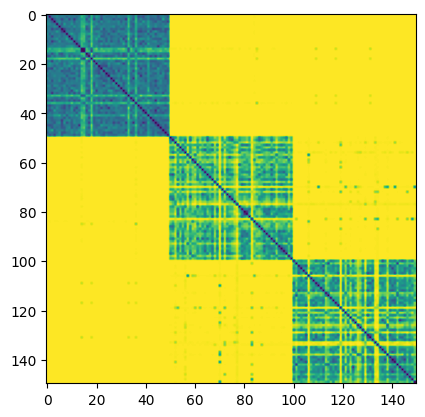

In [5]:
plt.imshow(spud_class.block[:spud_class.len_A, :spud_class.len_A])


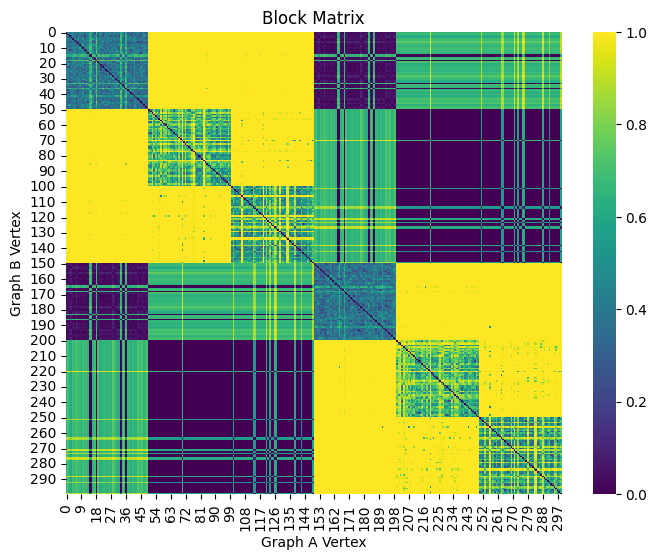

In [6]:
spud_class.plot_heat_map()

Time it took to calculate the embedding: 0.79
Calculating the classification Score.
RF-GAP score is accuracy
RF score on full embedding: 0.9666666666666667
Cross Embedding score: 0.97
Fraction of Samples Closest to thier Match: 0.19431111111111107


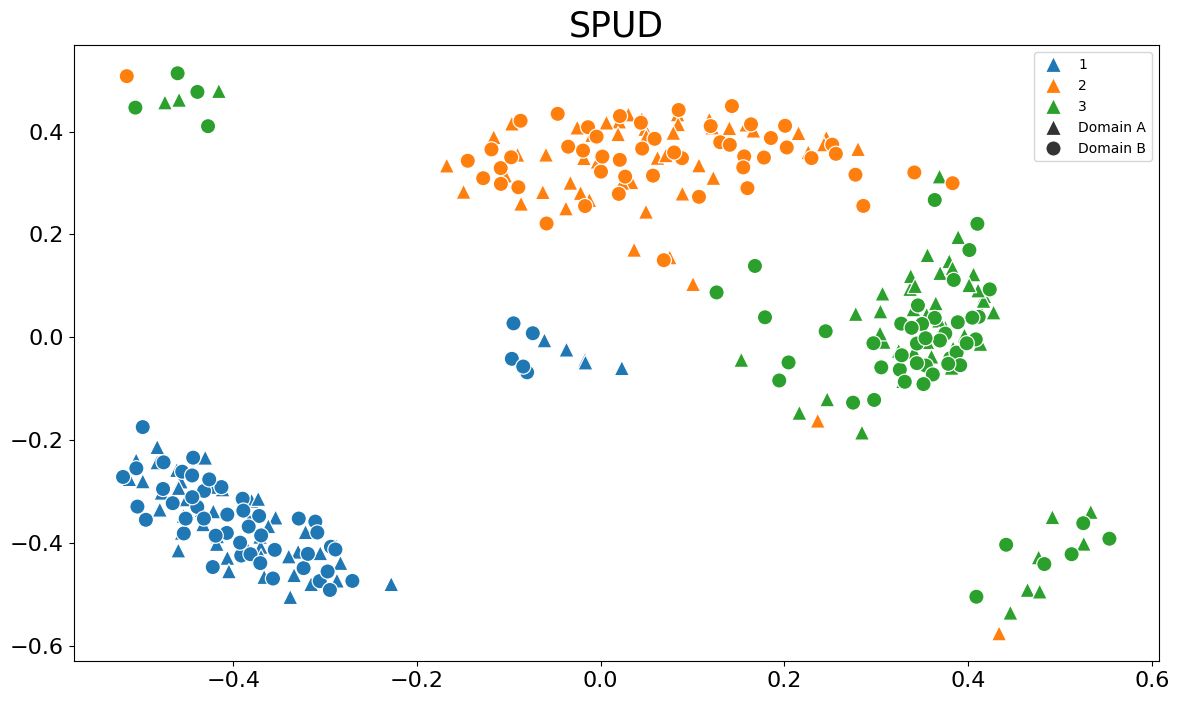

Time it took complete the plots: 0.4


In [7]:
spud_class.plot_emb(labels = dc.labels_doubled, show_anchors = False, show_lines = False)

# Applying RF GAP for MASH

In [8]:
#Create an RF Proximities function
def use_rf_proximities_MASH(self, tuple):
    """Creates RF proximities similarities
    
        tuple should be a tuple with position 0 being the data and position 1 being the labels"""
    #Initilize Class
    rf_class = RFGAP(prediction_type="classification", y=tuple[1], prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True) #Change Classification to regression

    #Fit it for Data A
    rf_class.fit(tuple[0], y = tuple[1])

    #Get promities
    dataA = rf_class.get_proximities()

    #Reset len_A and other varables
    if self.len_A == 2:
        self.len_A = len(tuple[0]) 

    elif self.len_B == 2:
        self.len_B = len(tuple[0])

    #Scale it and check to ensure no devision by 0
    if np.max(dataA[~np.isinf(dataA)]) != 0:

      dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 

    #Reset inf values
    dataA[np.isinf(dataA)] = 1

    return 1 - dataA

In [9]:
#Initialize SPUD Class
mash_class = MASH(distance_measure_A = use_rf_proximities_MASH, distance_measure_B= use_rf_proximities_MASH, knn = 3, verbose = 3, DTM = "log")

#Fit SPUD
mash_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:10])

Time Data Below
 Time it took to execute SGDM for domain A:  0.21414
 Time it took to execute the graph for domain A:  0.00221
 Time it took to execute SGDM for domain B:  0.21608
 Time it took to execute the graph for domain B:  0.00211
 Time it took to compute merge_graphs function:  0.0167
 Time it took to compute similarity_matrix function:  0.00041
Using optimal t value of 18
 Time it took to compute diffusion process:  0.11853
Fit process finished. We recommend calling optimize_by_creating_connections.


Time it took to calculate the embedding: 0.31245
Calculating the classification Score.
RF-GAP score is accuracy
Cross Embedding score: 0.9333333333333333
Fraction of Samples Closest to thier Match: 0.16177777777777777
RF score trained on full Embedding: 0.95


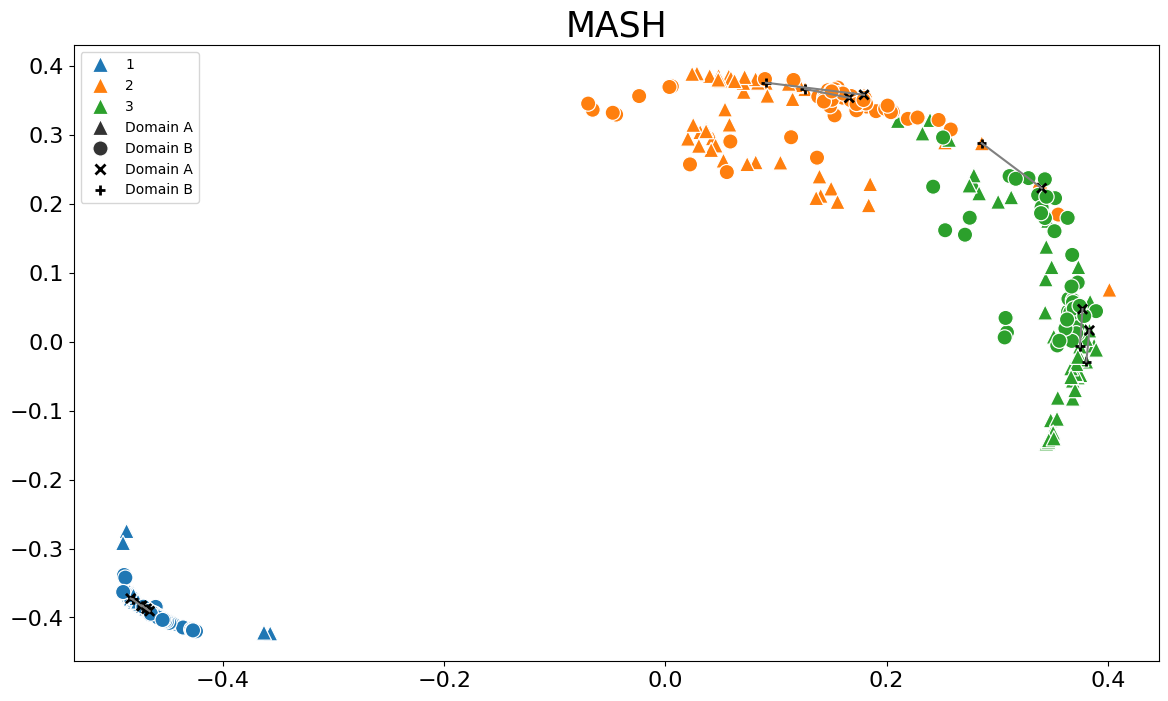

In [10]:
mash_class.plot_emb(labels = dc.labels_doubled, show_anchors = True, show_lines = False)

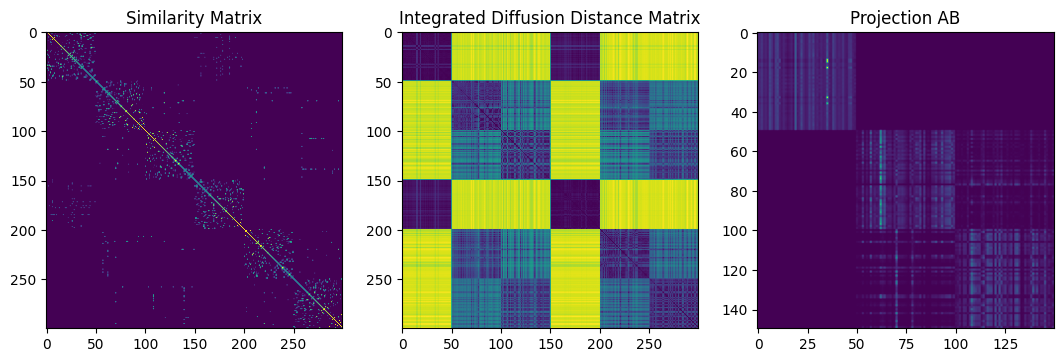

In [11]:
mash_class.plot_heat_maps()

Time Data Below
 Time it took to execute the graph for domain A:  0.07024
 Time it took to compute kernal A:  0.00014
 Time it took to execute the graph for domain B:  0.06472
 Time it took to compute kernal B:  8e-05
 Time it took to compute merge_graphs function:  0.01955
 Time it took to compute similarity_matrix function:  0.00032
Using optimal t value of 21
 Time it took to compute diffusion process:  0.21857
Fit process finished. We recommend calling optimize_by_creating_connections.


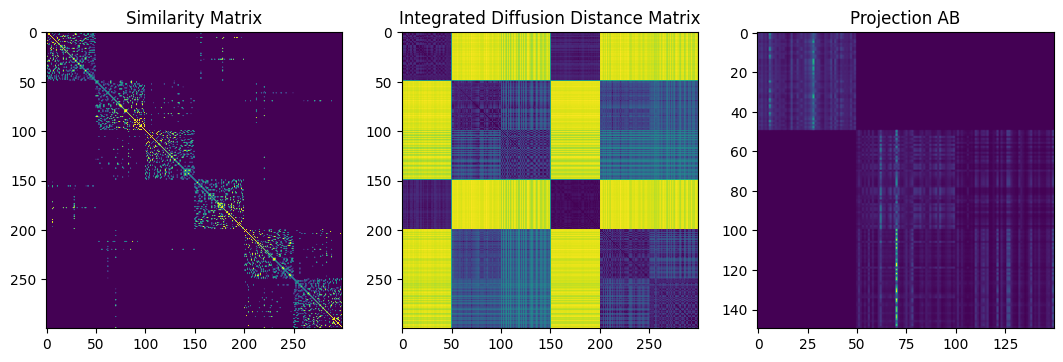

In [12]:
#Initialize SPUD Class
mash_class2 = MASH(knn = 8, verbose = 3, DTM = "log")
mash_class2.fit(dataA = dc.split_A, dataB = dc.split_B, known_anchors = dc.anchors[:4])
mash_class2.plot_heat_maps()

Time it took to calculate the embedding: 0.26956
Calculating the classification Score.
RF-GAP score is accuracy
Cross Embedding score: 0.6666666666666666
Fraction of Samples Closest to thier Match: 0.2477333333333333
RF score trained on full Embedding: 0.92


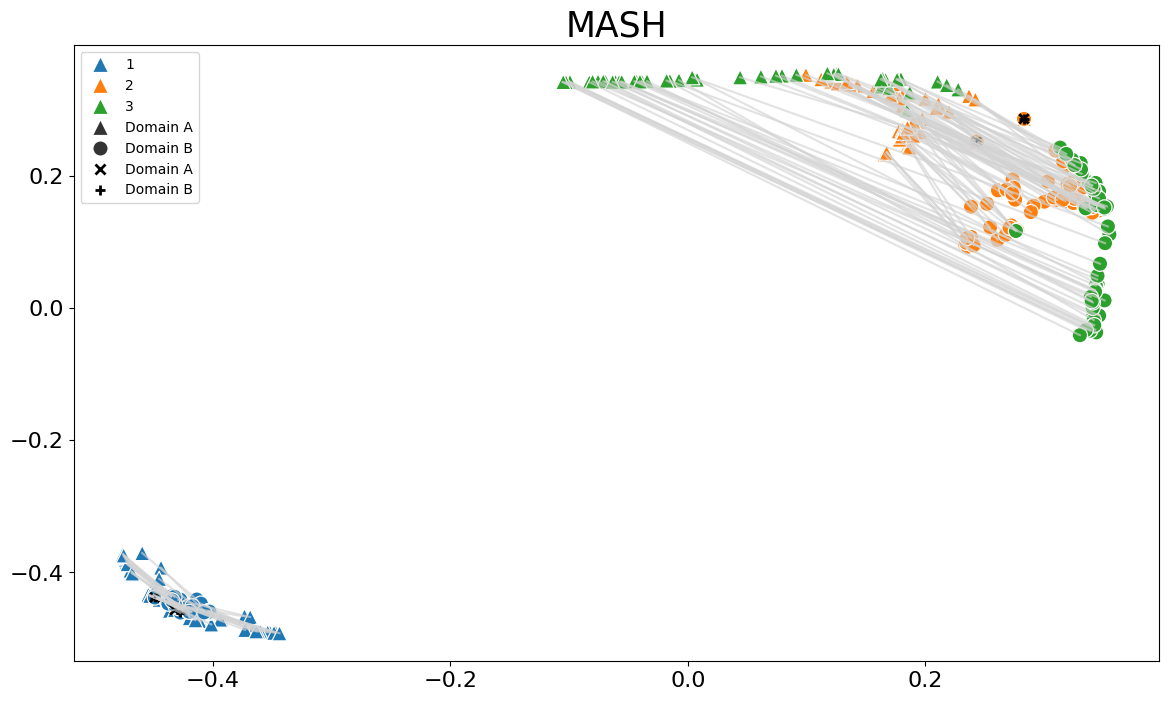

In [13]:
mash_class2.plot_emb(labels = dc.labels_doubled)

<><><><><> Beggining Tests. Original Connections show below <><><><><>


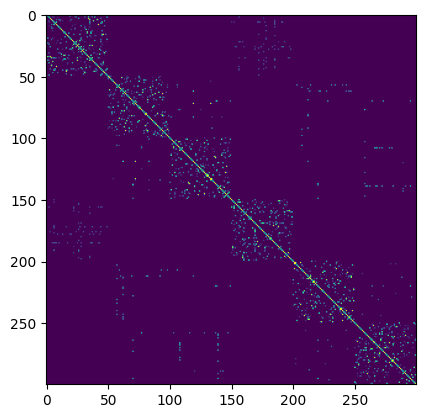

Edges wont be set with similarity measure above: 0.91
<><><><><><><><><><><><>    Starting Epoch 0    <><><><><><><><><><><><><>
Total number of Known_connections: 2324
New connections found: 30


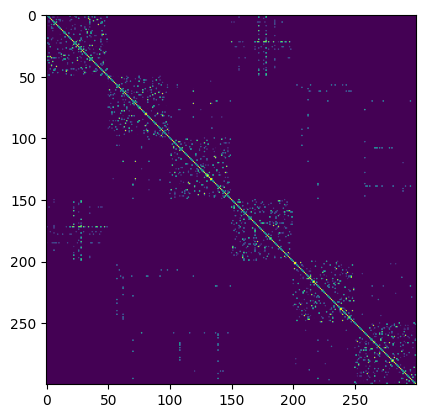

Using optimal t value of 12
The new connections worsened the alignment by 0.0075
-----------     Pruning the new connections. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 1    <><><><><><><><><><><><><>
Total number of Known_connections: 2324
New connections found: 30


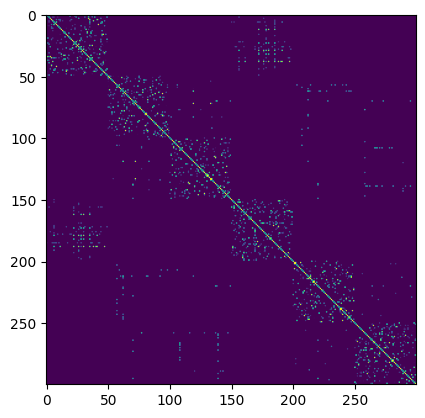

Using optimal t value of 13
The new connections worsened the alignment by 0.0008333333333333334
-----------     Pruning the new connections. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 2    <><><><><><><><><><><><><>
Total number of Known_connections: 2324
New connections found: 30


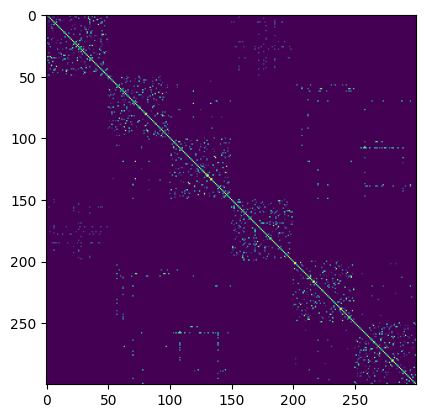

Using optimal t value of 15
The new connections worsened the alignment by 0.003333333333333333
-----------     Pruning the new connections. Continuing...    -----------

Using optimal t value of 18
Added Hold Out Anchor Conections


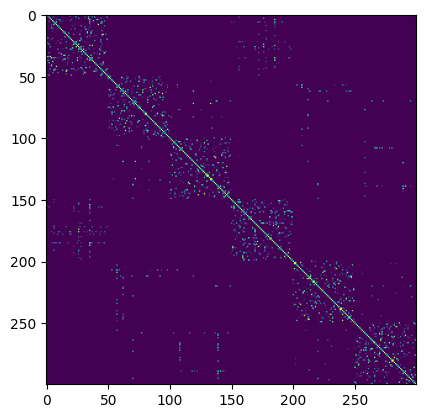

<><><><><><><><><><<><><><><<> Epochs Finished <><><><><><><><><><><><><><><><><>


False

In [14]:
mash_class.optimize_by_creating_connections(epochs=3, connection_limit= 30, threshold = 0.9, hold_out_anchors=dc.anchors[4:8])

Calculating the classification Score.


RF-GAP score is accuracy
Cross Embedding score: 0.9333333333333333
Fraction of Samples Closest to thier Match: 0.15857777777777776
RF score trained on full Embedding: 0.9533333333333334


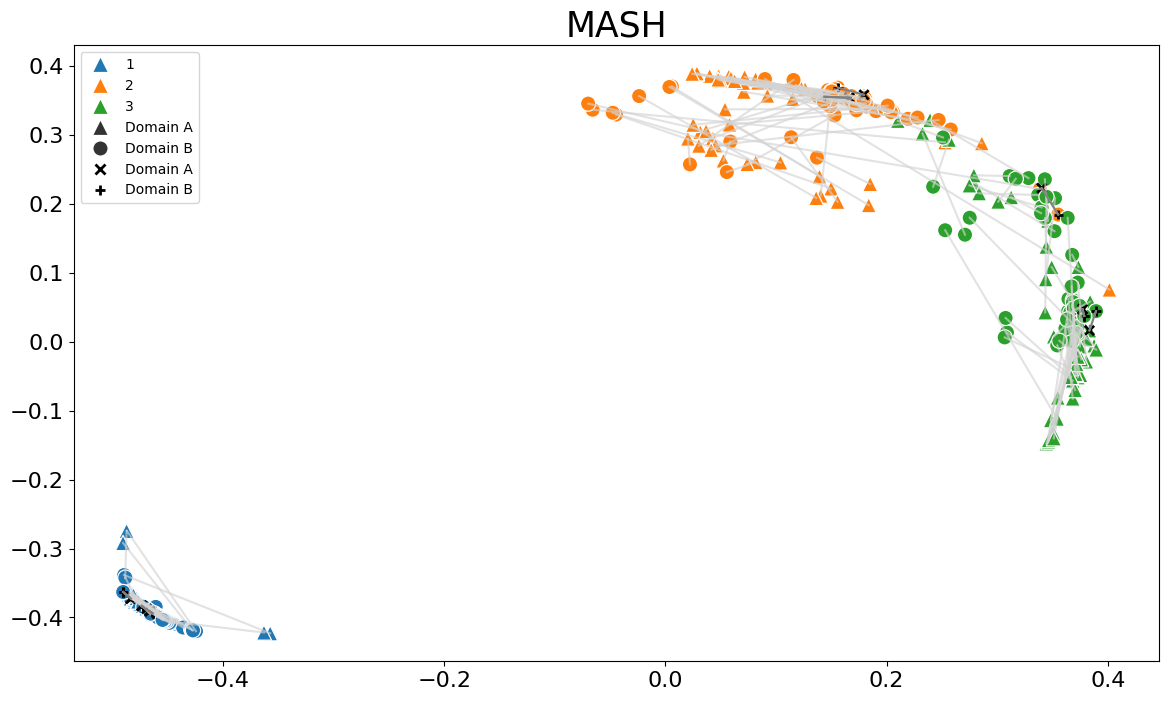

In [15]:
mash_class.plot_emb(labels = dc.labels_doubled)

# Using RF-Extend

### MASH

In [1]:
from Helpers.Pipeline_Helpers import *
from mashspud import MASH
import numpy as np
import pandas as pd
import Main.test_manifold_algorithms as tma
from mashspud import SPUD
from Helpers.rfgap import RFGAP
import matplotlib.pyplot as plt

2024-11-14 11:48:21.707821: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 11:48:21.711632: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 11:48:21.724433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 11:48:21.745200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 11:48:21.751435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 11:48:21.766930: I tensorflow/core/platform/cpu_feature_gu

In [11]:
dc = tma.test_manifold_algorithms(csv_file="Hydrodynamics.csv", split = "random", percent_of_anchors= [0.2], verbose = 4, random_state= 42)

MDS initialized with 2 components

 
 
---------------------------       Initalizing class with Hydrodynamics.csv data       ---------------------------

The knn values are: (2, 9, 16, 23, 30, 37, 44, 51, 58, 65)


In [12]:
mash_class = MASH(distance_measure_A = get_rf_proximites, distance_measure_B= get_rf_proximites, knn = 6, t = -1, verbose = 3, DTM = "log")
mash_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:10])

Time Data Below
 Time it took to execute SGDM for domain A:  0.27809
 Time it took to execute the graph for domain A:  0.00609
 Time it took to execute SGDM for domain B:  0.27818
 Time it took to execute the graph for domain B:  0.00542
 Time it took to compute merge_graphs function:  0.21813
 Time it took to compute similarity_matrix function:  0.0014
Using optimal t value of 7
 Time it took to compute diffusion process:  0.43008
Fit process finished. We recommend calling optimize_by_creating_connections.


In [13]:
mash_class.get_scores(labels = dc.labels_doubled)

Time it took to calculate the embedding: 6.80251
Calculating the R squared score.
RF-GAP score is R^2


(0.5061456400742115, -0.5733768362643359, 0.13148783324946556)

In [5]:
from sklearn.model_selection import train_test_split

#Initialize SPUD Class
mash_class = MASH(distance_measure_A = get_rf_proximites, distance_measure_B= get_rf_proximites, knn = 6, t = -1, verbose = 3, DTM = "log")

X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(dc.split_A, dc.labels, test_size=0.2, random_state=42)
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(dc.split_B, dc.labels, test_size=0.2, random_state=42)
labels_doubled = np.hstack((y_A_train, y_A_test, y_B_train, y_B_test))

#Fit SPUD
mash_class.fit(dataA = (X_A_train, X_A_test, y_A_train), dataB = (X_B_train, X_B_test, y_B_train), known_anchors = dc.anchors[:10])

Time Data Below


ValueError: Found input variables with inconsistent numbers of samples: [614, 154]

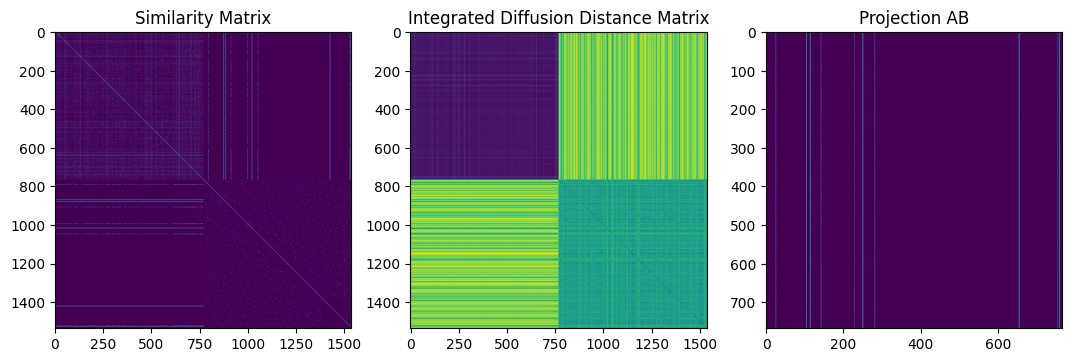

In [26]:
mash_class.plot_heat_maps()

Calculating the R squared score.
RF-GAP score is R^2
Cross Embedding score: 1.0
Fraction of Samples Closest to thier Match: 0.4065229627821181
RF score trained on full Embedding: 1.0


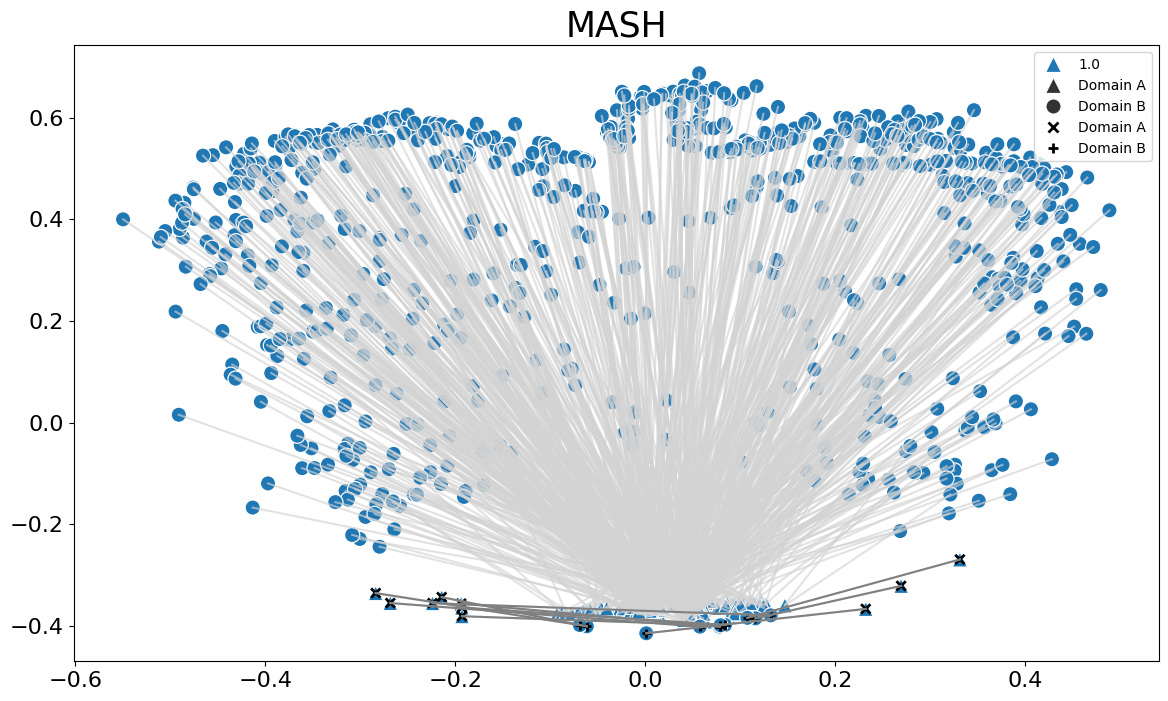

In [29]:
mash_class.plot_emb(labels=np.ones_like(dc.labels_doubled))

Calculating the classification Score.
RF-GAP score is accuracy
Cross Embedding score: 0.7433333333333334
Fraction of Samples Closest to thier Match: 0.15951111111111113
RF score trained on full Embedding: 0.7733333333333333


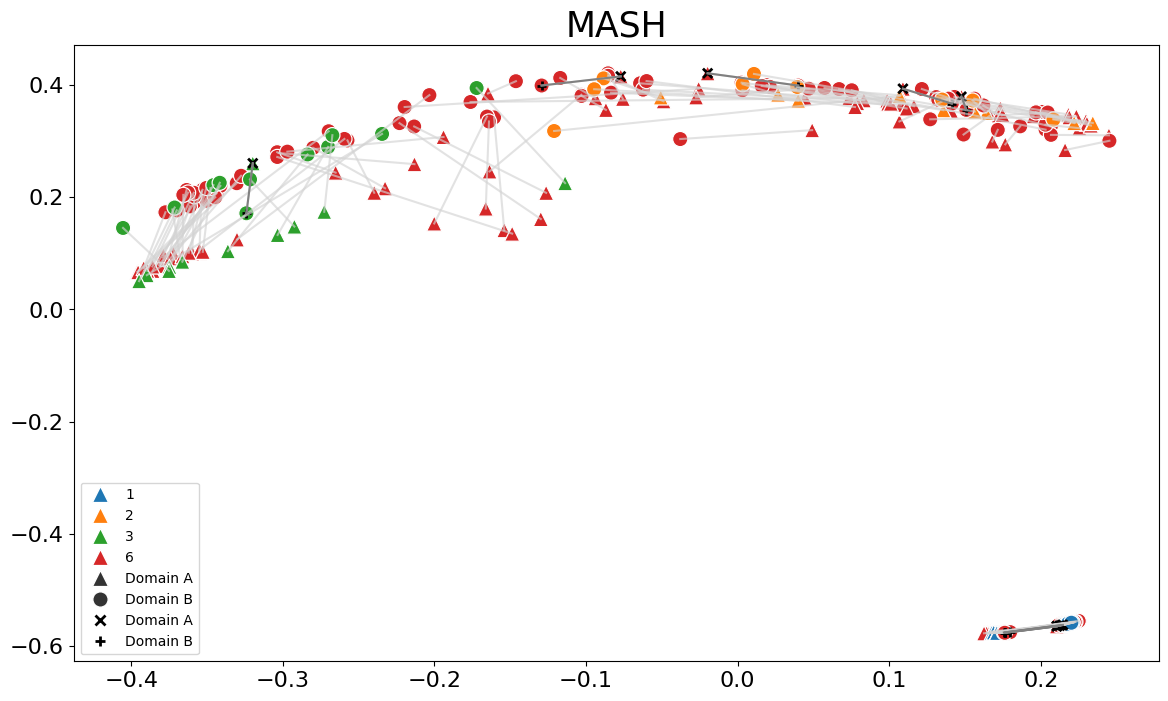

In [19]:
labels_greyed = np.hstack((np.ones_like(y_A_train)+5, y_A_test, np.ones_like(y_B_train)+5, y_B_test))
mash_class.plot_emb(labels = labels_greyed)

### Spud

In [20]:
from sklearn.model_selection import train_test_split

#Initialize SPUD Class
spud_class = SPUD(distance_measure_A = rf_test_proximities, distance_measure_B= rf_test_proximities, knn = 3, verbose = 4)

X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(dc.split_A, dc.labels, test_size=0.2, random_state=42)
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(dc.split_B, dc.labels, test_size=0.2, random_state=42)
labels_doubled = np.hstack((y_A_train, y_A_test, y_B_train, y_B_test))

#Fit SPUD
spud_class.fit(dataA = (X_A_train, X_A_test, y_A_train), dataB = (X_B_train, X_B_test, y_B_train), known_anchors = dc.anchors[:10])

Time it took to compute SGDM:  0.42
Time it took to execute graphtools.Graph functions:  0.14
Time it took to execute merge_graphs function:  0.0
Time it took to execute get_block function:  0.01
<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>


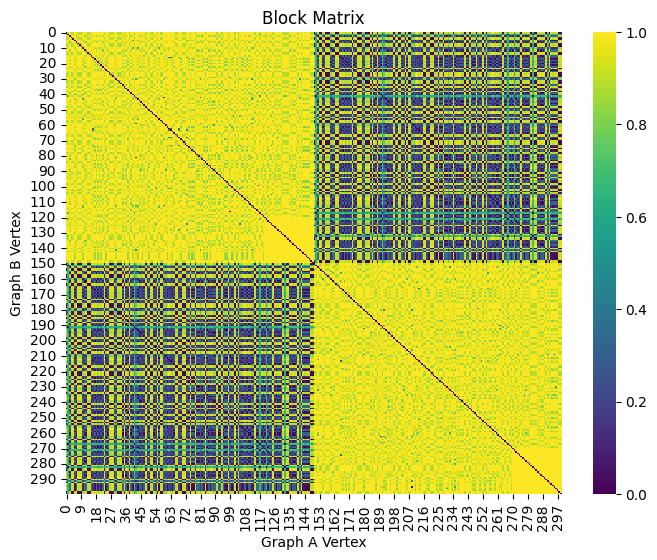

In [21]:
spud_class.plot_heat_map()

Time it took to calculate the embedding: 0.77
Calculating the classification Score.
RF-GAP score is accuracy
RF score on full embedding: 0.9733333333333334
Cross Embedding score: 0.9833333333333334
Fraction of Samples Closest to thier Match: 0.0010222222222222223


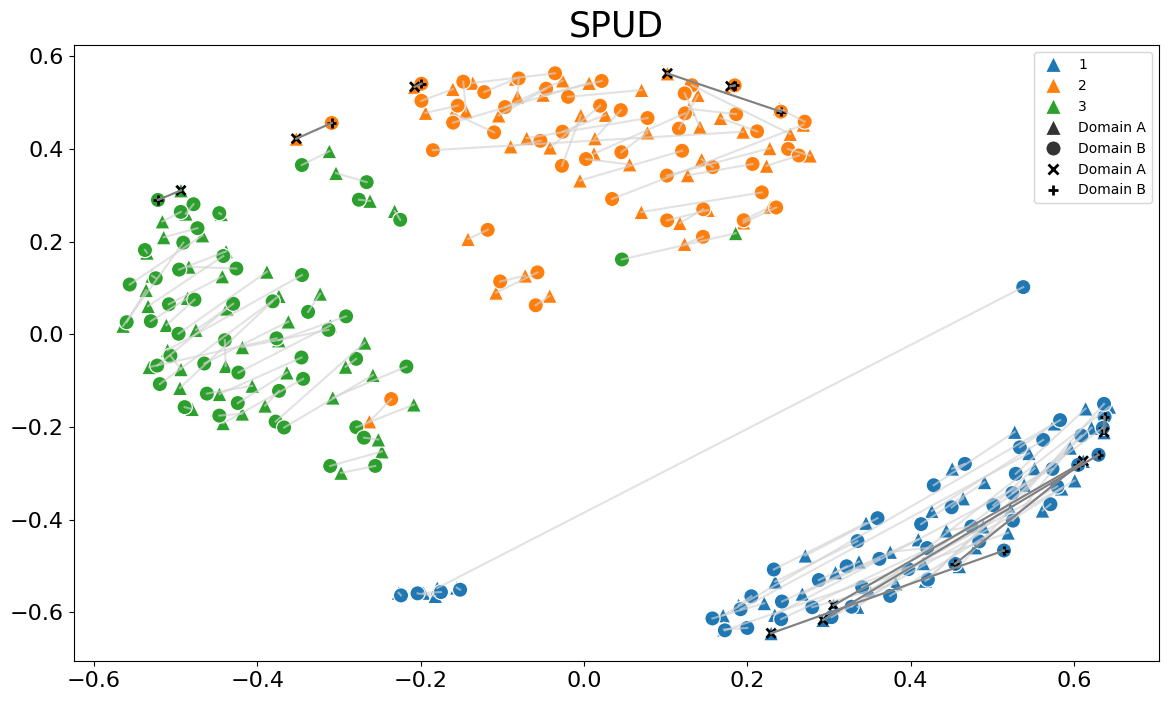

Time it took complete the plots: 0.44


In [22]:
spud_class.plot_emb(labels = labels_doubled)

Calculating the classification Score.
RF-GAP score is accuracy
RF score on full embedding: 0.77
Cross Embedding score: 0.7833333333333333
Fraction of Samples Closest to thier Match: 0.0010222222222222223


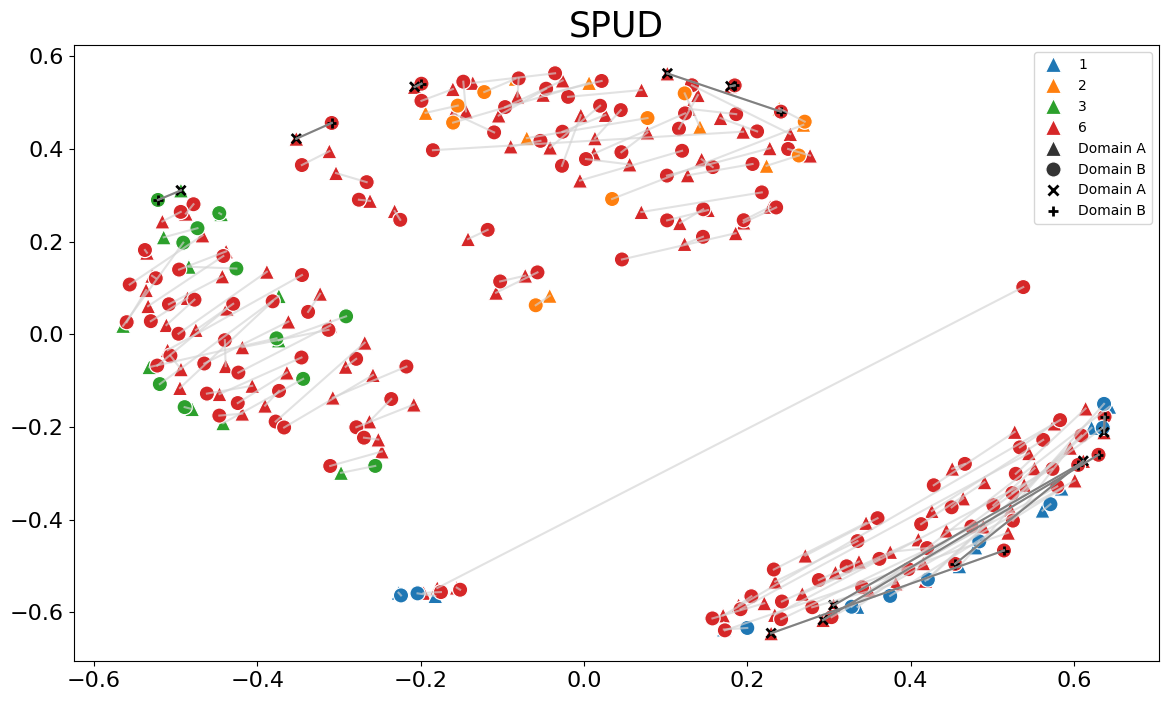

Time it took complete the plots: 0.45


In [23]:
labels_greyed = np.hstack((np.ones_like(y_A_train)+5, y_A_test, np.ones_like(y_B_train)+5, y_B_test))
spud_class.plot_emb(labels = labels_greyed)